<a href="https://colab.research.google.com/github/andersonsam/shuswap_lake_modelling/blob/main/main_shuswap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lake level, water temperature, and air temperature data from: https://www.shuswaplakewatch.com/datatable.php#stats  

Wind data from ERA5 reanalysis: https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5

Shuswap lake level data from Environment and Climate Change Canada (e.g. https://wateroffice.ec.gc.ca/report/historical_e.html?stn=08LE070&dataType=Daily&parameterType=Level&year=1976&mode=Graph&y1Max=1&y1Min=1&scale=normal) has a large gap (1986 - 2010), so here we use the Shuswap Lake Watch data which has continuous records for a longer period in the modern record (2008 - present).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from google.colab import drive
from datetime import datetime
from netCDF4 import Dataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Softmax,  Dropout, SimpleRNN, LSTM
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping

# Data preperation

In [2]:
#manual cleaning of shuswaplakewatch data -- this was done outside of this notebook and cleaned data is loaded here

#dates out of order: 
#October 28, 2015 in June 2013
#October 27-28, 2017 in November 2017
#May 25, 2018 in November 2017

#missing date:
#June 14, 2017

#1-m too high:
#August 26, 2009

In [3]:
#mount google drive to access data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/'
data_filename_lake = 'shuswap_lake_data.csv'
data_filename_u = 'sicamous_u_2008_2020.nc'
data_filename_v = 'sicamous_v_2008_2020.nc'

#open lake data
df = pd.read_csv(data_dir + data_filename_lake)
df = df.set_index('Date')
df.head()

,Level (m),Level_change (cm),Surface_water_temperature (Celcius),Air_temperature_low (Celcius),Air_temperature_high (Celcius),Code,Bridge_clearance (m),Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
Date,,,,,,,,,,,,,,,,
2008-01-01,345.486,-0.6,5.6,-4.9,0.7,ccc,7.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,345.477,-0.9,5.0,-0.7,5.3,ccc,7.041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,345.467,-1.0,5.0,-1.3,2.1,ccx,7.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,345.455,-1.2,5.0,0.7,5.0,ccr,7.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-05,345.442,-1.3,5.0,0.7,6.7,ccr,7.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#extract variables from lake dataset
level = df['Level (m)']
level_change = df['Level_change (cm)']
temp_water = df['Surface_water_temperature (Celcius)']
temp_water_change = temp_water.iloc[1:].values - temp_water.iloc[:-1].values
temp_air_max = df['Air_temperature_high (Celcius)']
temp_air_min = df['Air_temperature_low (Celcius)']

date_str = df.index
date = [datetime.strptime(ds,'%Y-%m-%d') for ds in date_str]

In [6]:
#rearrange data as 2D array: row = level, column = day of year; this way we can calculate seasonal average/normal

years_full = range(2008,2021)
N_years_full = len(years_full)
level_mean = np.zeros(365)
level_yearly = np.zeros((N_years_full,365))

for yy, year in enumerate(years_full):
  dd = [date_str[kk] for kk in range(len(df)) if date_str[kk].startswith(str(year))][:365]
  level_yearly[yy,:] = level.loc[dd].values
level_mean = np.mean(level_yearly, axis = 0)
level_std = np.std(level_yearly, axis = 0)
level_min = np.min(level_yearly, axis = 0)
level_max = np.max(level_yearly, axis = 0)

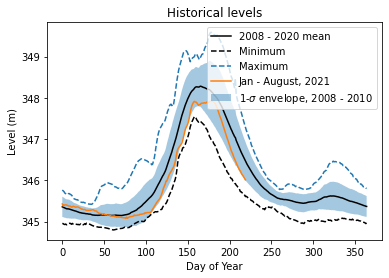

In [7]:
#visualize summary of level series

dates_2021 = [date_str[kk] for kk in range(len(df)) if date_str[kk].startswith('2021')] #dates of 2021

fig, ax = plt.subplots()

ax.fill_between(x = np.arange(365), y1 = level_mean + level_std, y2 = level_mean - level_std, alpha = 0.4, label = '1-$\sigma$ envelope, 2008 - 2010')
ax.plot(level_mean, color = 'k', label = '2008 - 2020 mean')
ax.plot(level_min, 'k--', label = 'Minimum')
ax.plot(level_max, linestyle = '--', label = 'Maximum')
ax.plot(level.loc[dates_2021].values, label = 'Jan - August, 2021')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Level (m)')
ax.set_title('Historical levels')
ax.legend()

plt.show()

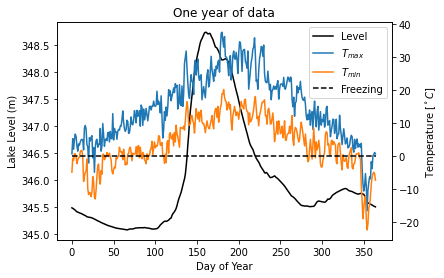

In [8]:
#visualize one year of level data

fig, ax = plt.subplots()

days = np.arange(0*365,1*365)

ax.plot(level.values[days], color = 'k', label = 'Level')
ax2 = ax.twinx()
ax2.plot(temp_air_max.values[days], label = '$T_{max}$')
ax2.plot(temp_air_min.values[days], label = '$T_{min}$')
ax2.plot([0,365],[0,0],'k--', label = 'Freezing')

ax.set_xlabel('Day of Year')
ax.set_ylabel('Lake Level (m)')
ax2.set_ylabel('Temperature [$^\circ C$]')
ax.set_title('One year of data')

#combine legends of both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)

plt.show()

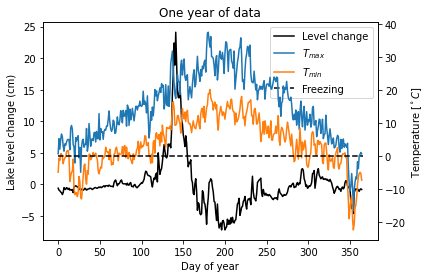

In [9]:
#visualize one year of level change data

fig, ax = plt.subplots()

days = np.arange(0*365,1*365)

ax.plot(level_change.values[days], color = 'k', label = 'Level change')
ax2 = ax.twinx()
ax2.plot(temp_air_max.values[days], label = '$T_{max}$')
ax2.plot(temp_air_min.values[days], label = '$T_{min}$')
ax2.plot([0,365],[0,0],'k--', label = 'Freezing')

ax.set_xlabel('Day of year')
ax.set_ylabel('Lake level change (cm)')
ax2.set_ylabel('Temperature [$^\circ C$]')
ax.set_title('One year of data')

#combine legends of both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)

plt.show()

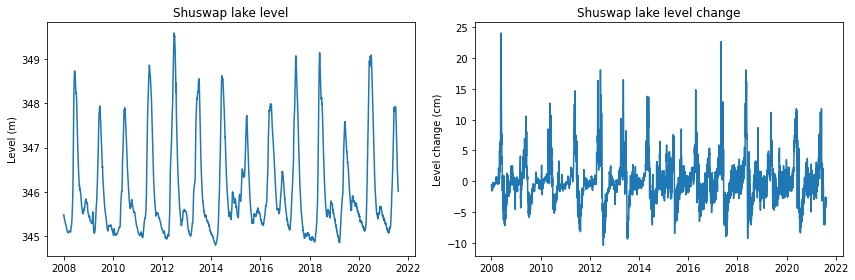

In [10]:
#visualize entire time series

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].plot(date,level)
ax[0].set_ylabel('Level (m)')
ax[0].set_title('Shuswap lake level')

ax[1].plot(date,level_change)
ax[1].set_ylabel('Level change (cm)')
ax[1].set_title('Shuswap lake level change')

plt.tight_layout()

plt.show()

In [11]:
#open netcdf wind files

data_u = Dataset(data_dir + data_filename_u)
lonERA = data_u.variables['longitude'][:] #in degrees E
latERA = data_u.variables['latitude'][:] #in degrees N
timeERA = data_u.variables['time'][:] #in hours since year 1900... not a great unit, but it's what ERA comes in
u = np.squeeze(data_u.variables['u10']) #in m/s

data_v = Dataset(data_dir + data_filename_v)
v = np.squeeze(data_v.variables['v10']) #in m/s

In [12]:
lonERA

masked_array(data=[-118.98],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

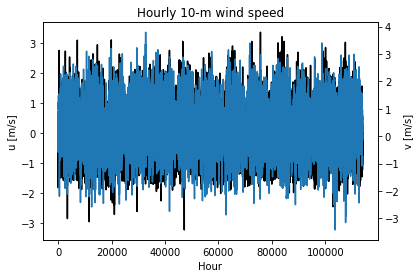

In [13]:
#visualize components of wind

fig, ax = plt.subplots()

ax.plot(u,'k', label = 'u')
ax.set_xlabel('Hour')
ax.set_ylabel('u [m/s]')

ax2 = ax.twinx()
ax2.plot(v, label = 'v')
ax2.set_ylabel('v [m/s]')

ax.set_title('Hourly 10-m wind speed')

plt.show()

In [15]:
#calculate magnitude of wind speed

wind_hourly = np.sqrt(u**2 + v**2)

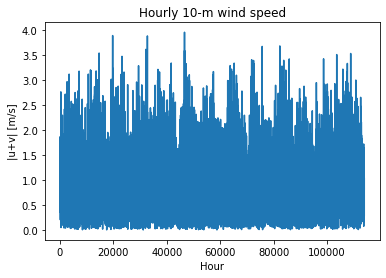

In [16]:
#visualize magnitude of wind

fig, ax = plt.subplots()

ax.plot(wind_hourly)
ax.set_xlabel('Hour')
ax.set_ylabel('|u+v| [m/s]')

ax.set_title('Hourly 10-m wind speed')

plt.show()

In [17]:
#calculate daily mean values

N_era = len(wind_hourly)
N_days = int(N_era / 24)

wind = np.zeros(N_days)

start = 0
for day in range(N_days):
  fin = start+24
  wind[day] = np.mean(wind_hourly[start:fin])
  start = fin

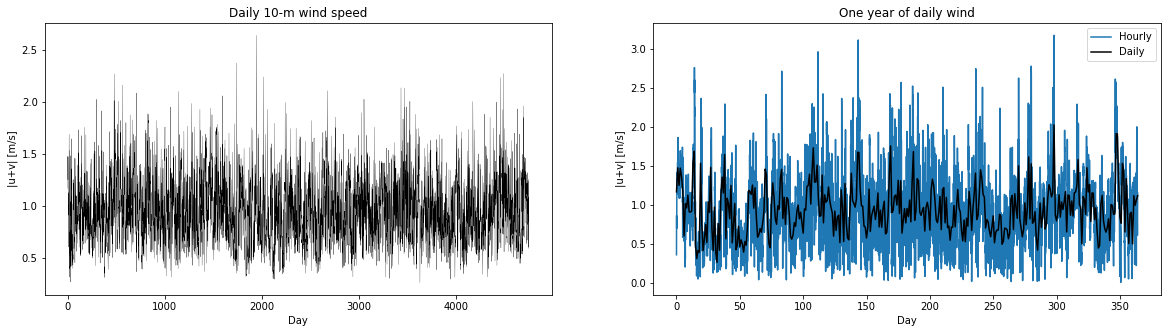

In [18]:
#visualize daily wind

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

ax[0].plot(wind, 'k', linewidth = 0.25)
ax[0].set_xlabel('Day')
ax[0].set_ylabel('|u+v| [m/s]')
ax[0].set_title('Daily 10-m wind speed')

ax[1].plot(np.linspace(0,364,365*24), wind_hourly[:365*24], label = 'Hourly')
ax[1].plot(wind[:365], 'k', label = 'Daily')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('|u+v| [m/s]')
ax[1].set_title('One year of daily wind')
ax[1].legend()

plt.show()

# Example: RNN to regress onto lake level, level change, lake temperature

In [34]:
#create input/output datasets

#input dimesions: obsevations, n_timesteps, n_vars
#output dimensions: observations

N_days_prior = 30 #number of days before present to use for prediction
N_observations = len(wind) - N_days_prior #total number of observations 
N_vars = 3 #number of input variables to use

x = np.zeros((N_observations, N_days_prior, N_vars)) #all input data (will be split into train/val/test)
y = np.zeros((N_observations,)) #all output data

#for each observation, input is previous N_days_prior of max/min temperatures, while output is next day
for kk in range(N_observations):
  x[kk,:,0] = temp_air_max[kk:kk+N_days_prior]
  x[kk,:,1] = temp_air_min[kk:kk+N_days_prior]
  x[kk,:,2] = wind[kk:kk+N_days_prior]

  #choose output variable to regress onto!
  y[kk] = level[kk+N_days_prior] #lake level
  y[kk] = level_change[kk+N_days_prior] #lake level change (daily)
  # y[kk] = temp_water[kk+N_days_prior] #water temperature

#now split into train/validate/test sets
N_train = 8*365
N_val = 2*365
N_test = 2*365

x_train = x[:N_train]
y_train = y[:N_train]

x_val = x[N_train : N_train+N_val]
y_val = y[N_train : N_train+N_val]

x_test = x[N_train+N_val : N_train+N_val+N_test]
y_test = y[N_train+N_val : N_train+N_val+N_test]

#and finally, normalize data

for var in range(N_vars): #standardize each input variable

  x_mean = np.mean(x_train[:,:,var])
  x_std = np.std(x_train[:,:,var])

  x_train[:,:,var] = (x_train[:,:,var] - x_mean) / x_std
  x_val[:,:,var] = (x_val[:,:,var] - x_mean) / x_std
  x_test[:,:,var] = (x_test[:,:,var] - x_mean) / x_std

#standardize output variable
y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [40]:
#build RNN model -- play around with this structure

# learning_rate = 1e-3

model = Sequential()
model.add(InputLayer(input_shape = (N_days_prior,N_vars)))
# model.add(SimpleRNN(20, activation = 'relu', return_sequences = True)) #RNN layer
model.add(SimpleRNN(20, activation = 'relu')) #RNN layer
model.add(Dropout(0.2))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

#compile model
model.compile(loss = 'MSE', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae'])
#learning_rate=learning_rate
#print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 20)                480       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [41]:
#train model

batch_size = 256

#define early stopping callback to use in all models
callbacks = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        verbose=1, 
                        patience = 10,
                        restore_best_weights = True)

model.fit(x_train, y_train,
          validation_data = (x_val, y_val),
          batch_size = batch_size,
          verbose = 1, 
          epochs = 400,

          callbacks = [callbacks])

Epoch 1/400
12/12 [==============================] - 1s 31ms/step - loss: 1.0703 - mae: 0.6856 - val_loss: 0.9303 - val_mae: 0.6554
Epoch 2/400
12/12 [==============================] - 0s 12ms/step - loss: 0.9479 - mae: 0.6058 - val_loss: 0.9099 - val_mae: 0.6202
Epoch 3/400
12/12 [==============================] - 0s 12ms/step - loss: 0.9192 - mae: 0.5943 - val_loss: 0.8835 - val_mae: 0.6208
Epoch 4/400
12/12 [==============================] - 0s 11ms/step - loss: 0.8995 - mae: 0.5974 - val_loss: 0.8590 - val_mae: 0.6228
Epoch 5/400
12/12 [==============================] - 0s 10ms/step - loss: 0.8664 - mae: 0.5875 - val_loss: 0.8147 - val_mae: 0.5975
Epoch 6/400
12/12 [==============================] - 0s 12ms/step - loss: 0.7858 - mae: 0.5643 - val_loss: 0.7345 - val_mae: 0.5752
Epoch 7/400
12/12 [==============================] - 0s 11ms/step - loss: 0.7223 - mae: 0.5480 - val_loss: 0.6755 - val_mae: 0.5673
Epoch 8/400
12/12 [==============================] - 0s 11ms/step - loss: 0.

In [42]:
#use model to make predictions for train/val/test
y_train_predict_RNN = model.predict(x_train, batch_size = batch_size)
y_val_predict_RNN = model.predict(x_val, batch_size = batch_size)
y_test_predict_RNN = model.predict(x_test, batch_size = batch_size)

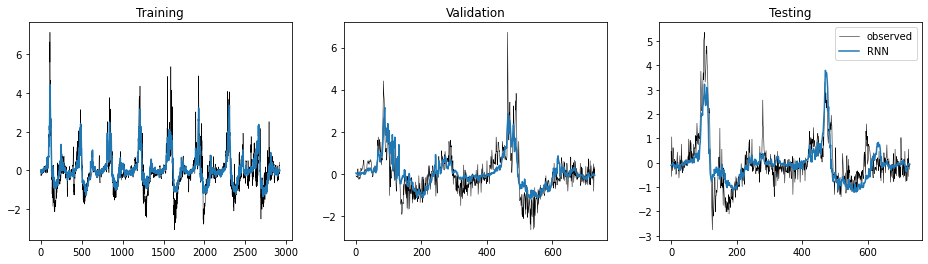

In [43]:
#visualize model predictions for train/val/test

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))

ax[0].plot(y_train, 'k', linewidth = 0.5)
ax[0].plot(y_train_predict_RNN)
ax[0].set_title('Training')

ax[1].plot(y_val, 'k', linewidth = 0.5)
ax[1].plot(y_val_predict_RNN)
ax[1].set_title('Validation')

ax[2].plot(y_test,'k', linewidth = 0.5, label = 'observed')
ax[2].plot(y_test_predict_RNN, label = 'RNN')
ax[2].set_title('Testing')

ax[2].legend()

plt.show()

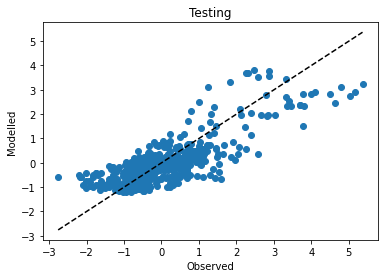

In [44]:
#modelled vs observed test set

plt.scatter(y_test, y_test_predict_RNN)
plt.xlabel('Observed')
plt.ylabel('Modelled')
plt.title('Testing')
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)],'k--')

plt.show()


# Example: RNN for regression -- lead times

In [49]:
#create input/output datasets

#input dimesions: obsevations, n_timesteps, n_vars
#output dimensions: observations

N_days_prior = 30 #number of days before present to use for prediction
N_days_future = 14
N_observations = len(wind) - N_days_prior - N_days_future #total number of observations 
N_vars = 3 #number of input variables to use

x = np.zeros((N_observations, N_days_prior, N_vars)) #all input data (will be split into train/val/test)
y = np.zeros((N_observations, N_days_future, )) #all output data

#for each observation, input is previous N_days_prior of max/min temperatures, while output is next day
for kk in range(N_observations):
  x[kk,:,0] = temp_air_max[kk:kk+N_days_prior]
  x[kk,:,1] = temp_air_min[kk:kk+N_days_prior]
  x[kk,:,2] = wind[kk:kk+N_days_prior]

  #choose output variable to regress onto!
  # y[kk] = level[kk+N_days_prior : kk+N_days_prior+N_days_future] #lake level
  y[kk] = level_change[kk+N_days_prior : kk+N_days_prior+N_days_future] #lake level change (daily)
  # y[kk] = temp_water[kk+N_days_prior : kk+N_days_prior+N_days_future] #water temperature

#now split into train/validate/test sets
N_train = 8*365
N_val = 2*365
N_test = 2*365

x_train = x[:N_train]
y_train = y[:N_train]

x_val = x[N_train : N_train+N_val]
y_val = y[N_train : N_train+N_val]

x_test = x[N_train+N_val : N_train+N_val+N_test]
y_test = y[N_train+N_val : N_train+N_val+N_test]

#and finally, normalize data

for var in range(N_vars): #standardize each input variable

  x_mean = np.mean(x_train[:,:,var])
  x_std = np.std(x_train[:,:,var])

  x_train[:,:,var] = (x_train[:,:,var] - x_mean) / x_std
  x_val[:,:,var] = (x_val[:,:,var] - x_mean) / x_std
  x_test[:,:,var] = (x_test[:,:,var] - x_mean) / x_std

#standardize output variable
y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [50]:
#build RNN model -- play around with this structure

# learning_rate = 1e-3

model = Sequential()
model.add(InputLayer(input_shape = (N_days_prior,N_vars)))
# model.add(SimpleRNN(20, activation = 'relu', return_sequences = True)) #RNN layer
model.add(SimpleRNN(20, activation = 'relu')) #RNN layer
model.add(Dropout(0.1))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(N_days_future, activation = 'linear'))

#compile model
model.compile(loss = 'MSE', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae'])
#learning_rate=learning_rate
#print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 20)                480       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_11 (Dense)             (None, 14)                1414      
Total params: 3,994
Trainable params: 3,994
Non-trainable params: 0
_________________________________________________________________


In [51]:
#train model

batch_size = 256

#define early stopping callback to use in all models
callbacks = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        verbose=1, 
                        patience = 10,
                        restore_best_weights = True)

model.fit(x_train, y_train,
          validation_data = (x_val, y_val),
          batch_size = batch_size,
          verbose = 1, 
          epochs = 400,

          callbacks = [callbacks])

Epoch 1/400
12/12 [==============================] - 1s 31ms/step - loss: 1.0298 - mae: 0.6710 - val_loss: 0.9672 - val_mae: 0.6891
Epoch 2/400
12/12 [==============================] - 0s 11ms/step - loss: 0.9716 - mae: 0.6330 - val_loss: 0.9238 - val_mae: 0.6616
Epoch 3/400
12/12 [==============================] - 0s 11ms/step - loss: 0.9323 - mae: 0.6092 - val_loss: 0.8839 - val_mae: 0.6355
Epoch 4/400
12/12 [==============================] - 0s 10ms/step - loss: 0.8954 - mae: 0.5843 - val_loss: 0.8468 - val_mae: 0.6122
Epoch 5/400
12/12 [==============================] - 0s 11ms/step - loss: 0.8618 - mae: 0.5706 - val_loss: 0.8097 - val_mae: 0.5972
Epoch 6/400
12/12 [==============================] - 0s 11ms/step - loss: 0.8252 - mae: 0.5657 - val_loss: 0.7655 - val_mae: 0.5777
Epoch 7/400
12/12 [==============================] - 0s 13ms/step - loss: 0.7632 - mae: 0.5481 - val_loss: 0.7000 - val_mae: 0.5528
Epoch 8/400
12/12 [==============================] - 0s 12ms/step - loss: 0.

In [52]:
#use model to make predictions for train/val/test
y_train_predict_RNN = model.predict(x_train, batch_size = batch_size)
y_val_predict_RNN = model.predict(x_val, batch_size = batch_size)
y_test_predict_RNN = model.predict(x_test, batch_size = batch_size)

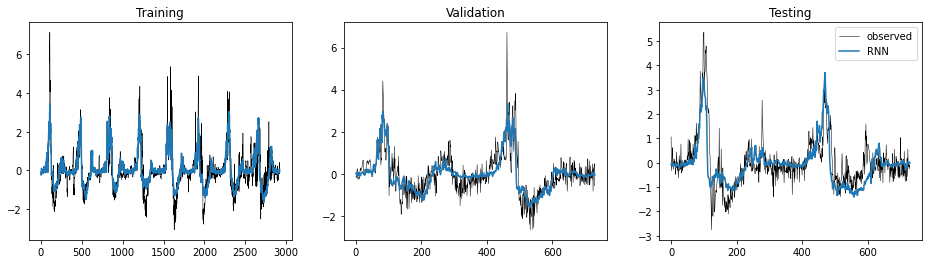

In [53]:
#visualize model predictions for train/val/test

var = 2

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))

ax[0].plot(y_train[:,var], 'k', linewidth = 0.5)
ax[0].plot(y_train_predict_RNN[:,var])
ax[0].set_title('Training')

ax[1].plot(y_val[:,var], 'k', linewidth = 0.5)
ax[1].plot(y_val_predict_RNN[:,var])
ax[1].set_title('Validation')

ax[2].plot(y_test[:,var],'k', linewidth = 0.5, label = 'observed')
ax[2].plot(y_test_predict_RNN[:,var], label = 'RNN')
ax[2].set_title('Testing')

ax[2].legend()

plt.show()

In [54]:
rmse = np.zeros(N_days_future)
for lead in range(N_days_future):
  rmse[lead] = np.sqrt(np.mean((y_test_predict_RNN[:,lead] - y_test[:,lead])**2))

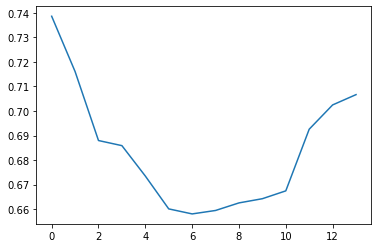

In [55]:
plt.plot(rmse)

In [56]:
#build ensemble of RNN models -- play around with this structure

N_models = 10
rmse = np.zeros((N_models, N_days_future)) #rows: models in ensemble; columns: lead time
y_test_predict_ensemble = np.zeros((N_test, N_days_future, N_models))

for kk in range(N_models):

  print('Model ', kk)

  model = Sequential()
  model.add(InputLayer(input_shape = (N_days_prior,N_vars)))
  # model.add(SimpleRNN(20, activation = 'relu', return_sequences = True)) #RNN layer
  model.add(SimpleRNN(20, activation = 'relu')) #RNN layer
  model.add(Dropout(0.1))
  model.add(Dense(30, activation = 'relu'))
  model.add(Dense(N_days_future, activation = 'linear'))

  #compile model
  model.compile(loss = 'MSE', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae'])

  #train model

  batch_size = 256

  #define early stopping callback to use in all models
  callbacks = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          verbose=1, 
                          patience = 10,
                          restore_best_weights = True)

  model.fit(x_train, y_train,
            validation_data = (x_val, y_val),
            batch_size = batch_size,
            verbose = 0, 
            epochs = 400,
            callbacks = [callbacks])

  #use model to make predictions for train/val/test
  y_train_predict_RNN = model.predict(x_train, batch_size = batch_size)
  y_val_predict_RNN = model.predict(x_val, batch_size = batch_size)
  y_test_predict_RNN = model.predict(x_test, batch_size = batch_size)

  y_test_predict_ensemble[:,:,kk] = y_test_predict_RNN

  for lead in range(N_days_future):
    rmse[kk,lead] = np.sqrt(np.mean((y_test_predict_RNN[:,lead] - y_test[:,lead])**2))

#model ensemble
y_test_predict_ensemble_mean = np.mean(y_test_predict_ensemble, axis = -1)
rmse_ensemble = np.zeros(N_days_future)
for lead in range(N_days_future):
    rmse_ensemble[lead] = np.sqrt(np.mean((y_test_predict_ensemble_mean[:,lead] - y_test[:,lead])**2))

Model  0
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Model  1
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Model  2
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model  3
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Model  4
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Model  5
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Model  6
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Model  7
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model  8
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Model  9
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping


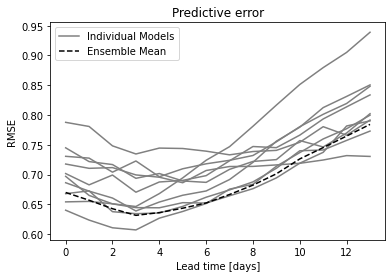

In [58]:
fig, ax = plt.subplots()
ax.plot(rmse[1:,:].T, 'gray')
ax.plot(rmse[0,:], 'gray', label = 'Individual Models')
ax.plot(rmse_ensemble, 'k--', label = 'Ensemble Mean')

ax.set_ylabel('RMSE')
ax.set_xlabel('Lead time [days]')
ax.set_title('Predictive error')
ax.legend()

plt.show()

In [59]:
#does the predictive power for the next day (lead = 0) change if more or fewer days are used as output?

#create input/output datasets

#input dimesions: obsevations, n_timesteps, n_vars
#output dimensions: observations

N_days_prior = 30 #number of days before present to use for prediction
N_days_future = 14
N_observations = len(wind) - N_days_prior - N_days_future #total number of observations 
N_vars = 3 #number of input variables to use

x = np.zeros((N_observations, N_days_prior, N_vars)) #all input data (will be split into train/val/test)
y = np.zeros((N_observations, N_days_future, )) #all output data

#for each observation, input is previous N_days_prior of max/min temperatures, while output is next day
for kk in range(N_observations):
  x[kk,:,0] = temp_air_max[kk:kk+N_days_prior]
  x[kk,:,1] = temp_air_min[kk:kk+N_days_prior]
  x[kk,:,2] = wind[kk:kk+N_days_prior]

  #choose output variable to regress onto!
  # y[kk] = level[kk+N_days_prior : kk+N_days_prior+N_days_future] #lake level
  y[kk] = level_change[kk+N_days_prior : kk+N_days_prior+N_days_future] #lake level change (daily)
  # y[kk] = temp_water[kk+N_days_prior : kk+N_days_prior+N_days_future] #water temperature

#now split into train/validate/test sets
N_train = 8*365
N_val = 2*365
N_test = 2*365

x_train = x[:N_train]
y_train = y[:N_train]

x_val = x[N_train : N_train+N_val]
y_val = y[N_train : N_train+N_val]

x_test = x[N_train+N_val : N_train+N_val+N_test]
y_test = y[N_train+N_val : N_train+N_val+N_test]

#and finally, normalize data

for var in range(N_vars): #standardize each input variable

  x_mean = np.mean(x_train[:,:,var])
  x_std = np.std(x_train[:,:,var])

  x_train[:,:,var] = (x_train[:,:,var] - x_mean) / x_std
  x_val[:,:,var] = (x_val[:,:,var] - x_mean) / x_std
  x_test[:,:,var] = (x_test[:,:,var] - x_mean) / x_std

#standardize output variable
y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [60]:
#build ensemble of RNN models -- play around with this structure

rmse_next_day = np.zeros(N_days_future)

for lead in range(N_days_future):

  print('Training lead time = ', lead)

  model = Sequential()
  model.add(InputLayer(input_shape = (N_days_prior,N_vars)))
  # model.add(SimpleRNN(20, activation = 'relu', return_sequences = True)) #RNN layer
  model.add(SimpleRNN(20, activation = 'relu')) #RNN layer
  model.add(Dropout(0.1))
  model.add(Dense(30, activation = 'relu'))
  model.add(Dense(lead+1, activation = 'linear'))

  #compile model
  model.compile(loss = 'MSE', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae'])

  #train model
  batch_size = 256

  #define early stopping callback to use in all models
  callbacks = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          verbose=1, 
                          patience = 10,
                          restore_best_weights = True)

  model.fit(x_train, y_train[:,:lead+1],
            validation_data = (x_val, y_val[:,:lead+1]),
            batch_size = batch_size,
            verbose = 0, 
            epochs = 400,
            callbacks = [callbacks])

  #use model to make predictions for train/val/test
  y_train_predict_RNN = model.predict(x_train, batch_size = batch_size)
  y_val_predict_RNN = model.predict(x_val, batch_size = batch_size)
  y_test_predict_RNN = model.predict(x_test, batch_size = batch_size)

  rmse_next_day[lead] = np.sqrt(np.mean((y_test_predict_RNN[:,0] - y_test[:,0])**2))

Training lead time =  0
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Training lead time =  1
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Training lead time =  2
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Training lead time =  3
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Training lead time =  4
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Training lead time =  5
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Training lead time =  6
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Training lead time =  7
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Training lead time =  8
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Training lead time =  9
Rest

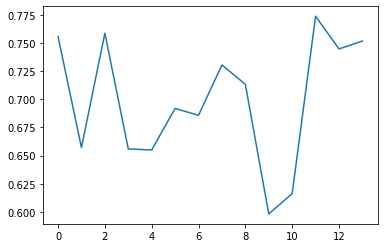

In [61]:
plt.plot(rmse_next_day)

# Example: RNN to classify level increase / decrease

In [75]:
#create input/output datasets

#input dimesions: obsevations, n_timesteps, n_vars
#output dimensions: observations

N_days_prior = 30 #number of days before present to use for prediction
N_observations = len(wind) - N_days_prior #total number of observations 
N_vars = 2 #number of input variables to use

x = np.zeros((N_observations, N_days_prior, N_vars)) #all input data (will be split into train/val/test)
y = np.zeros((N_observations,)) #all output data
y_value = np.zeros((N_observations,))

#for each observation, input is previous N_days_prior of max/min temperatures, while output is next day
for kk in range(N_observations):
  x[kk,:,0] = temp_air_max[kk:kk+N_days_prior]
  x[kk,:,1] = temp_air_min[kk:kk+N_days_prior]
  # x[kk,:,2] = wind[kk:kk+N_days_prior]

  #choose output variable to regress onto!
  y_value[kk] = level_change[kk+N_days_prior] #lake level change (daily)
  y_value[kk] = level_change[kk+N_days_prior] #lake level change (daily)
  # y[kk] = temp_water[kk+N_days_prior] #water temperature

# y[kk] = np.sign(y_value[kk]) #1 == increase, 0 == decrease
y[y_value>0] = 1

#now split into train/validate/test sets
N_train = 8*365
N_val = 2*365
N_test = 2*365

x_train = x[:N_train]
y_train = y[:N_train]

x_val = x[N_train : N_train+N_val]
y_val = y[N_train : N_train+N_val]

x_test = x[N_train+N_val : N_train+N_val+N_test]
y_test = y[N_train+N_val : N_train+N_val+N_test]

#and finally, normalize data

for var in range(N_vars): #standardize each input variable

  x_mean = np.mean(x_train[:,:,var])
  x_std = np.std(x_train[:,:,var])

  x_train[:,:,var] = (x_train[:,:,var] - x_mean) / x_std
  x_val[:,:,var] = (x_val[:,:,var] - x_mean) / x_std
  x_test[:,:,var] = (x_test[:,:,var] - x_mean) / x_std

Text(0, 0.5, 'Increase/decrease classification')

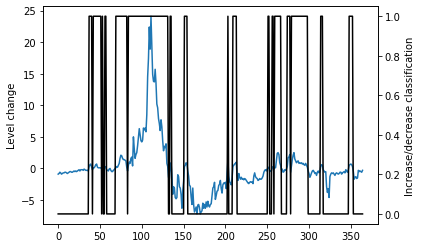

In [76]:
fig, ax = plt.subplots()

ax.plot(y_value[:365])
ax.set_ylabel('Level change')
ax2 = ax.twinx()
ax2.plot(y[:365],'k')
ax2.set_ylabel('Increase/decrease classification')

In [77]:
#build RNN model -- play around with this structure

# learning_rate = 1e-3

model = Sequential()
model.add(InputLayer(input_shape = (N_days_prior,N_vars)))
# model.add(SimpleRNN(20, activation = 'relu', return_sequences = True)) #RNN layer
model.add(SimpleRNN(20, activation = 'relu')) #RNN layer
model.add(Dropout(0.5))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output is either 0 or 1, so use sigmoid activation in final layer

#compile model
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
# model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(), metrics = ['mse'])
#print model summary
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_34 (SimpleRNN)    (None, 20)                460       
_________________________________________________________________
dropout_33 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [78]:
#train model

batch_size = 256

#define early stopping callback to use in all models
callbacks = EarlyStopping(monitor='val_accuracy', 
                        mode='max', 
                        verbose=1, 
                        patience = 10,
                        restore_best_weights = True)

model.fit(x_train, y_train,
          validation_data = (x_val, y_val),
          batch_size = batch_size,
          verbose = 1, 
          epochs = 400,

          callbacks = [callbacks])

Epoch 1/400
12/12 [==============================] - 2s 31ms/step - loss: 0.6917 - accuracy: 0.5185 - val_loss: 0.6503 - val_accuracy: 0.5904
Epoch 2/400
12/12 [==============================] - 0s 12ms/step - loss: 0.6613 - accuracy: 0.5603 - val_loss: 0.6178 - val_accuracy: 0.5945
Epoch 3/400
12/12 [==============================] - 0s 10ms/step - loss: 0.6424 - accuracy: 0.5815 - val_loss: 0.6040 - val_accuracy: 0.6096
Epoch 4/400
12/12 [==============================] - 0s 11ms/step - loss: 0.6418 - accuracy: 0.6041 - val_loss: 0.6027 - val_accuracy: 0.6274
Epoch 5/400
12/12 [==============================] - 0s 11ms/step - loss: 0.6087 - accuracy: 0.6298 - val_loss: 0.5716 - val_accuracy: 0.6630
Epoch 6/400
12/12 [==============================] - 0s 10ms/step - loss: 0.5875 - accuracy: 0.6658 - val_loss: 0.5195 - val_accuracy: 0.7356
Epoch 7/400
12/12 [==============================] - 0s 11ms/step - loss: 0.5520 - accuracy: 0.6986 - val_loss: 0.4707 - val_accuracy: 0.7849
Epoch 

In [79]:
#use model to make predictions for train/val/test
y_train_predict_RNN = model.predict(x_train, batch_size = batch_size).round().squeeze()
y_val_predict_RNN = model.predict(x_val, batch_size = batch_size).round().squeeze()
y_test_predict_RNN = model.predict(x_test, batch_size = batch_size).round().squeeze()

In [80]:
accuracy_train = len(np.argwhere(y_train_predict_RNN == y_train)) / N_train
accuracy_val = len(np.argwhere(y_val_predict_RNN == y_val)) / N_val
accuracy_test = len(np.argwhere(y_test_predict_RNN == y_test)) / N_test

print('Training accuracy:   ', np.round(accuracy_train, decimals = 2))
print('Validation accuracy: ', np.round(accuracy_val, decimals = 2))
print('Testing accuracy:    ', np.round(accuracy_test, decimals = 2))

Training accuracy:    0.78
Validation accuracy:  0.81
Testing accuracy:     0.76


In [81]:
#calculate confusion matrices

cm_train = confusion_matrix(y_pred = y_train_predict_RNN, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_val_predict_RNN, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_test_predict_RNN, y_true = y_test)

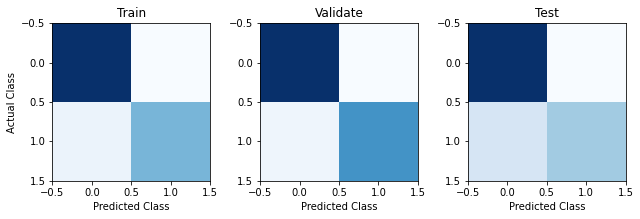

In [82]:
#visualize confusion matrices

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (9,3))

ax[0].imshow(cm_train, cmap = 'Blues')
ax[0].set_ylabel('Actual Class')
ax[0].set_xlabel('Predicted Class')
ax[0].set_title('Train')

ax[1].imshow(cm_val, cmap = 'Blues')
ax[1].set_xlabel('Predicted Class')
ax[1].set_title('Validate')

ax[2].imshow(cm_test, cmap = 'Blues')
ax[2].set_xlabel('Predicted Class')
ax[2].set_title('Test')

plt.tight_layout()